<h1 align="center">CAS Modeling</h1>

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import normal_ad    
from lime import lime_tabular
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, GammaRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',None)

## Importing data

In [3]:
df= pd.read_csv('CAS Preprocessed.csv')
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

,X,Y,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,crashLocation2,crashSeverity,crashSHDescription,crashYear,debris,directionRoleDescription,ditch,fatalCount,fence,flatHill,guardRail,houseOrBuilding,kerb,light,minorInjuryCount,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,phoneBoxEtc,postOrPole,region,roadCharacter,roadLane,roadSurface,roadworks,schoolBus,seriousInjuryCount,slipOrFlood,speedLimit,strayAnimal,streetLight,suv,taxi,tlaName,trafficControl,trafficIsland,trafficSign,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,claimAmount
0,1406914.0,4915023.0,0.0,0.0,0.0,1.0,0.0,None,2000/2001,MIDLAND ST,PORTSMOUTH DRIVE,Non-Injury Crash,No,2000,0.0,East,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Overcast,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Otago Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,70.0,0.0,None,0.0,0.0,Dunedin City,Give way,0.0,0.0,0.0,0.0,0.0,0.0,Urban,1.0,0.0,0.0,Fine,91105.0
1,1799023.0,5814728.0,0.0,0.0,0.0,3.0,0.0,North,2011/2012,SH 1N,KILLARNEY ROAD,Non-Injury Crash,Yes,2012,0.0,South,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Bright sun,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Waikato Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,60.0,0.0,None,0.0,0.0,Hamilton City,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine,91554.0
2,1741193.0,5976099.0,0.0,0.0,0.0,1.0,1.0,North,2006/2007,SH 1N,SAUNDERS ROAD,Non-Injury Crash,Yes,2007,0.0,North,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Twilight,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Auckland Region,Bridge,2-way,Sealed,0.0,0.0,0.0,0.0,100.0,0.0,None,0.0,0.0,Auckland,Nil,0.0,0.0,0.0,0.0,0.0,0.0,Open,0.0,0.0,0.0,Light rain,81110.0
3,1790288.0,5837387.0,0.0,0.0,0.0,1.0,1.0,North,2006/2007,RIVERVIEW ROAD,HAKARIMATA ROAD,Non-Injury Crash,No,2006,0.0,North,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Overcast,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Waikato Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,100.0,0.0,None,0.0,0.0,Waikato District,Nil,0.0,0.0,0.0,0.0,0.0,0.0,Open,0.0,0.0,0.0,Light rain,89788.0
4,1615675.0,5423627.0,0.0,0.0,0.0,2.0,0.0,None,2003/2004,TALBOT ST,ELIZABETH ST,Non-Injury Crash,No,2003,0.0,West,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Overcast,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tasman Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,50.0,0.0,None,0.0,0.0,Tasman District,Give way,0.0,0.0,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine,54222.0


In [4]:
df.shape

(758006, 62)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758006 entries, 0 to 758005
Data columns (total 62 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          758006 non-null  float64
 1   Y                          758006 non-null  float64
 2   bicycle                    758006 non-null  float64
 3   bridge                     758006 non-null  float64
 4   bus                        758006 non-null  float64
 5   carStationWagon            758006 non-null  float64
 6   cliffBank                  758006 non-null  float64
 7   crashDirectionDescription  758006 non-null  object 
 8   crashFinancialYear         758006 non-null  object 
 9   crashLocation1             758006 non-null  object 
 10  crashLocation2             758006 non-null  object 
 11  crashSeverity              758006 non-null  object 
 12  crashSHDescription         758006 non-null  object 
 13  crashYear                  75

In [6]:
df = df.loc[(df['seriousInjuryCount'] > 0) & (df['seriousInjuryCount'] < 5)] 

In [7]:
df.shape

(44716, 62)

In [8]:
null_columns = df.columns[df.isnull().any()]
(df[null_columns].isnull().sum()/len(df))*100

Series([], dtype: float64)

In [9]:
df['Log_claimAmount'] = np.log(df['claimAmount'])

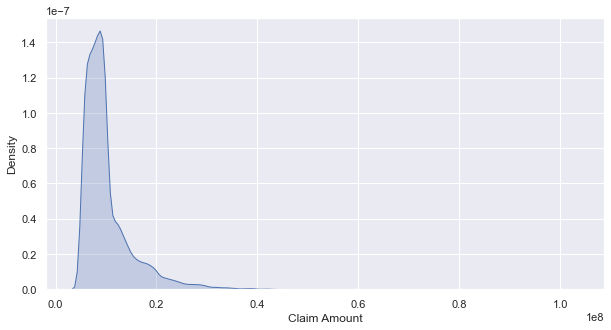

In [10]:
plt.figure(figsize=(10,5))
plt.xlabel('Claim Amount')
plt.ylabel('Density')
sns.kdeplot(df['claimAmount'],shade=True)
plt.show()

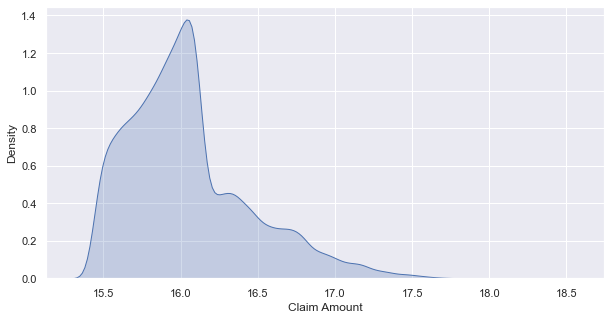

In [11]:
plt.figure(figsize=(10,5))
plt.xlabel('Claim Amount')
plt.ylabel('Density')
sns.kdeplot(df['Log_claimAmount'],shade=True)
plt.show()

## Modeling

### LIME

In [12]:
def lime(model, X_test, y_test, X_train, y_train,seed_ = 108):
    explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names= X_train.columns)
    random.seed(seed_)
    idx = random.randint(1, len(X_test))
    print("Prediction : ", model.predict(X_test.iloc[idx]))
    print("Actual :     ", y_test.iloc[idx])

    explanation = explainer.explain_instance(X_test.iloc[idx], model.predict, num_features=len(X_train.columns))
    return explanation

In [13]:
def multicollinearity_assumption(model, features, label, feature_names=None):        
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [14]:
def calculate_residuals(model, features, label, transformation=False):
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label.squeeze(1), 'Predicted': predictions})
    if not transformation:
        df_results['Residuals'] = (df_results['Actual'] - df_results['Predicted'])
        df_results['Residuals_per'] = abs(df_results['Residuals']/df_results['Actual'])
    if transformation:
        df_results['ActualT'] = np.exp(df_results['Actual'])
        df_results['PredictedT'] = np.exp(df_results['Predicted'])
        df_results['Residuals'] = (df_results['ActualT'] - df_results['PredictedT'])
        df_results['Residuals_per'] = abs(df_results['Residuals']/df_results['ActualT'])
        
    return df_results

In [15]:
def homoscedasticity_assumption(model, features, label):     
    df_results = calculate_residuals(model, features, label)

    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    plt.title('Residuals')
    plt.show()  

In [16]:
def linear_assumption(model, features, label):        
    df_results = calculate_residuals(model, features, label)
    
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [17]:
def Feature_imp(Model,n,X,y):
    model = Model
    # create the RFE model and select attributes
    rfe = RFE(model,n_features_to_select= n)
    rfe = rfe.fit(X, y)
    # summarize the selection of the attributes
    return pd.DataFrame({'Decision':rfe.support_,'Feature':X.columns})

In [18]:
def normal_errors_assumption(model, features, label):
    df_results = calculate_residuals(model, features, label)
    print('Residuals are normally distributed')
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()

### Gamma distribution

In [19]:
formula = "claimAmount ~ bicycle+bridge+bus+carStationWagon+cliffBank+debris+ditch+fence+flatHill+guardRail+houseOrBuilding+kerb+moped+motorcycle+NumberOfLanes+objectThrownOrDropped+otherObject+otherVehicleType+overBank+parkedVehicle+phoneBoxEtc+postOrPole+roadworks+schoolBus+slipOrFlood+speedLimit+strayAnimal+streetLight+suv+taxi+trafficIsland+trafficSign+train+tree+truck+unknownVehicleType+urban+vanOrUtility+vehicle+waterRiver"
y, X = dmatrices(formula, df, return_type='dataframe')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [21]:
Feature = Feature_imp(GammaRegressor(),10,X_test,y_test)
Feature[Feature.Decision == True]

,Decision,Feature
1,True,flatHill[T.Hill Road]
4,True,streetLight[T.On]
6,True,bicycle
9,True,carStationWagon
10,True,cliffBank
18,True,motorcycle
30,True,speedLimit
32,True,suv
38,True,truck
40,True,vanOrUtility


In [22]:
X_train_gamma, y_train_gamma = X_train[['Intercept','flatHill[T.Hill Road]','streetLight[T.On]','streetLight[T.Off]','bicycle','carStationWagon','motorcycle','NumberOfLanes','speedLimit','suv','vanOrUtility']],y_train
X_test_gamma, y_test_gamma = X_test[['Intercept','flatHill[T.Hill Road]','streetLight[T.On]','streetLight[T.Off]','bicycle','carStationWagon','motorcycle','NumberOfLanes','speedLimit','suv','vanOrUtility']],y_test

In [23]:
model_gamma = sm.GLM(y_train_gamma, X_train_gamma,family=sm.families.Gamma(link=sm.families.links.Log())).fit()

In [24]:
model_gamma.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
=======================================================================
Model:                GLM                AIC:              1185739.2808
Link Function:        Log                BIC:              -369381.2575
Dependent Variable:   claimAmount        Log-Likelihood:   -5.9286e+05 
Date:                 2022-04-18 19:37   LL-Null:          -5.9539e+05 
No. Observations:     35772              Deviance:         5570.0      
Df Model:             10                 Pearson chi2:     7.58e+03    
Df Residuals:         35761              Scale:            0.21198     
Method:               IRLS                                             
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept             15.7048   0.0128 1230.2205 0.0000 15.6798 15.7298
flatHill[T.Hill Road]  0.0280   0.0057    4.8836 0.0000  0.0168  0.0393
streetLight[T.On]      0.0378   0.0071    5.3315 0.0000  0.0239  0.0517
streetLight[T.Off]    -0.0242   0.0072   -3.3429 0.0008 -0.0384 -0.0100
bicycle               -0.0870   0.0090   -9.6651 0.0000 -0.1047 -0.0694
carStationWagon        0.1760   0.0038   46.9173 0.0000  0.1686  0.1834
motorcycle            -0.0571   0.0066   -8.6412 0.0000 -0.0701 -0.0442
NumberOfLanes         -0.0136   0.0031   -4.3983 0.0000 -0.0196 -0.0075
speedLimit             0.0033   0.0001   29.0108 0.0000  0.0031  0.0035
suv                    0.1567   0.0081   19.2475 0.0000  0.1408  0.1727
vanOrUtility           0.1706   0.0063   26.9046 0.0000  0.1582  0.1831
=======================================================================

"""

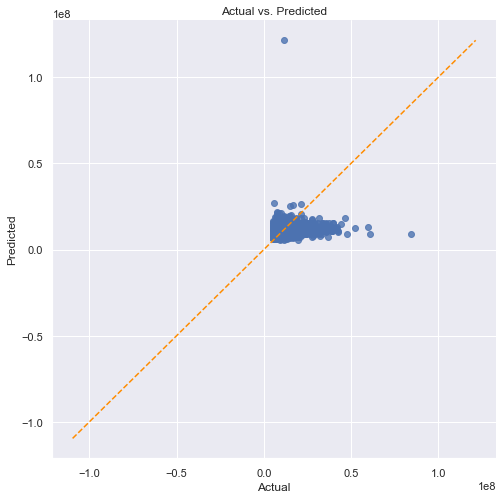

In [25]:
linear_assumption(model_gamma,X_test_gamma,y_test_gamma)

Residuals are normally distributed


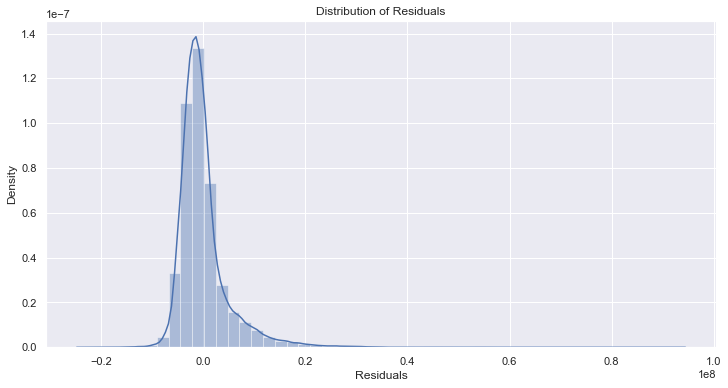

In [26]:
normal_errors_assumption(model_gamma,X_train_gamma,y_train_gamma)

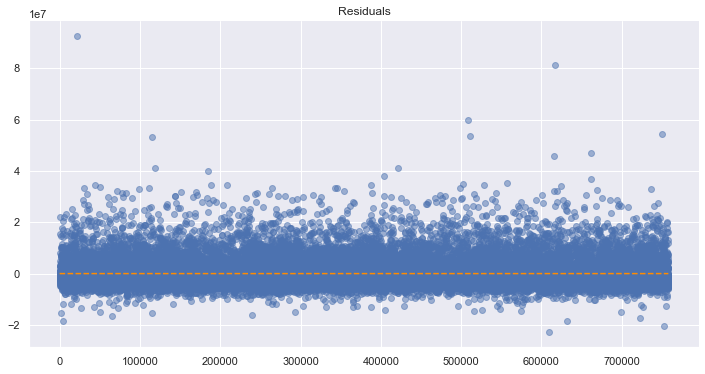

In [27]:
homoscedasticity_assumption(model_gamma,X_train_gamma,y_train_gamma)

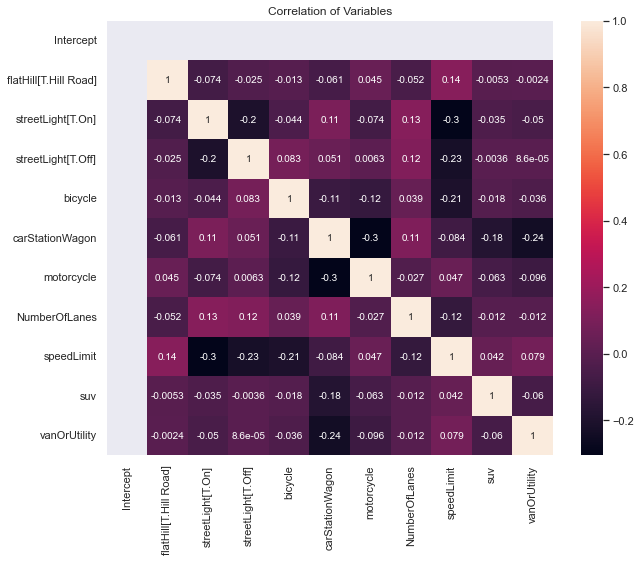

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Intercept: 27.50147211628303
flatHill[T.Hill Road]: 1.0267771279332933
streetLight[T.On]: 1.2582426329401106
streetLight[T.Off]: 1.1805197085503358
bicycle: 1.1186520867047336
carStationWagon: 1.346703306742644
motorcycle: 1.210866405089684
NumberOfLanes: 1.0564095305328516
speedLimit: 1.3104775882034263
suv: 1.076409823697335
vanOrUtility: 1.1389832548507204

1 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied


In [28]:
multicollinearity_assumption(model_gamma,X_train_gamma,y_train_gamma,X_train_gamma.columns)

In [29]:
ypred_gtrain = model_gamma.predict(X_train_gamma)
RMSE_gtrain = np.sqrt(mean_squared_error(y_train_gamma,ypred_gtrain))
print("RMSE Of Gamma for train:",RMSE_gtrain)
MAE_gtrain = mean_absolute_error(y_train_gamma,ypred_gtrain)
print("MAE Of Gamma for train:",MAE_gtrain)

RMSE Of Gamma for train: 4961599.810074337
MAE Of Gamma for train: 3265500.017278048


In [30]:
ypred_gtest = model_gamma.predict(X_test_gamma)
RMSE_gtest = np.sqrt(mean_squared_error(y_test_gamma,ypred_gtest))
print("RMSE Of Gamma for test:",RMSE_gtest)
MAE_gtest = mean_absolute_error(y_test_gamma,ypred_gtest)
print("MAE Of Gamma for test:",MAE_gtest)

RMSE Of Gamma for test: 5149434.287398637
MAE Of Gamma for test: 3305178.2027267795


In [31]:
print(RMSE_gtrain/(y_train_gamma.max()-y_train_gamma.min()))
print(RMSE_gtest/(y_test_gamma.max()-y_test_gamma.min()))

claimAmount    0.05127
dtype: float64
claimAmount    0.064901
dtype: float64


In [32]:
df_gamma_Results = calculate_residuals(model_gamma,X_test_gamma,y_test_gamma)
df_gamma_Results.head()

,Actual,Predicted,Residuals,Residuals_per
78998,6387031.0,1.069654e+07,-4.309507e+06,0.674728
158493,7249253.0,1.254557e+07,-5.296316e+06,0.730602
291929,13347718.0,1.311748e+07,2.302333e+05,0.017249
80365,5894983.0,1.040986e+07,-4.514874e+06,0.765884
150572,5846619.0,1.069654e+07,-4.849919e+06,0.829525


In [33]:
df_gamma_Results[df_gamma_Results['Residuals_per']<.5]

,Actual,Predicted,Residuals,Residuals_per
291929,13347718.0,1.311748e+07,2.302333e+05,0.017249
281057,5716290.0,8.328645e+06,-2.612355e+06,0.457002
342847,9794885.0,1.049950e+07,-7.046148e+05,0.071937
234195,10026368.0,7.380886e+06,2.645482e+06,0.263852
276084,10455700.0,1.063946e+07,-1.837571e+05,0.017575
...,...,...,...,...
205374,7977793.0,9.410201e+06,-1.432408e+06,0.179549
317894,7977647.0,1.100056e+07,-3.022912e+06,0.378923
612184,13269888.0,9.410201e+06,3.859687e+06,0.290861
82859,24159258.0,1.311748e+07,1.104177e+07,0.457041


In [34]:
df_gamma_Results[df_gamma_Results['Residuals_per']>.5]

,Actual,Predicted,Residuals,Residuals_per
78998,6387031.0,1.069654e+07,-4.309507e+06,0.674728
158493,7249253.0,1.254557e+07,-5.296316e+06,0.730602
80365,5894983.0,1.040986e+07,-4.514874e+06,0.765884
150572,5846619.0,1.069654e+07,-4.849919e+06,0.829525
572721,9949562.0,1.500430e+07,-5.054734e+06,0.508036
...,...,...,...,...
474727,43949428.0,1.472288e+07,2.922655e+07,0.665004
690606,5248201.0,9.096096e+06,-3.847895e+06,0.733184
88121,5455948.0,9.012949e+06,-3.557001e+06,0.651949
157113,5497924.0,1.094186e+07,-5.443932e+06,0.990180


### LIME

In [35]:
explanation_gamma = lime(model_gamma,X_test_gamma,y_test_gamma,X_train_gamma,y_train_gamma,1)
explanation_gamma.show_in_notebook()

Prediction :  None    8.712867e+06
dtype: float64
Actual :      claimAmount    8726930.0
Name: 63157, dtype: float64


### Log normal distribution

In [36]:
formula = "Log_claimAmount ~ bicycle+bridge+bus+carStationWagon+cliffBank+debris+ditch+fence+flatHill+guardRail+houseOrBuilding+kerb+moped+motorcycle+NumberOfLanes+objectThrownOrDropped+otherObject+otherVehicleType+overBank+parkedVehicle+phoneBoxEtc+postOrPole+roadworks+schoolBus+slipOrFlood+speedLimit+strayAnimal+streetLight+suv+taxi+trafficIsland+trafficSign+train+tree+truck+unknownVehicleType+urban+vanOrUtility+vehicle+waterRiver"
y, X = dmatrices(formula, df, return_type='dataframe')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [38]:
Feature = Feature_imp(LinearRegression(),10,X_test,y_test)
Feature[Feature.Decision == True]

,Decision,Feature
5,True,urban[T.Urban]
8,True,bus
9,True,carStationWagon
20,True,objectThrownOrDropped
24,True,parkedVehicle
29,True,slipOrFlood
32,True,suv
33,True,taxi
39,True,unknownVehicleType
40,True,vanOrUtility


In [39]:
X_train_ols,y_train_ols = X_train[['Intercept','urban[T.Urban]','bus','carStationWagon','otherVehicleType','parkedVehicle','suv','truck','vanOrUtility']],y_train
X_test_ols,y_test_ols = X_test[['Intercept','urban[T.Urban]','bus','carStationWagon','otherVehicleType','parkedVehicle','suv','truck','vanOrUtility']],y_test

In [40]:
model_ols = sm.GLM(y_train_ols, X_train_ols,family=sm.families.Gaussian(link=sm.families.links.identity())).fit()

In [41]:
model_ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:               GLM              AIC:            31281.5368  
Link Function:       identity         BIC:            -369953.0981
Dependent Variable:  Log_claimAmount  Log-Likelihood: -15632.     
Date:                2022-04-18 19:38 LL-Null:        -18377.     
No. Observations:    35772            Deviance:       5019.1      
Df Model:            8                Pearson chi2:   5.02e+03    
Df Residuals:        35763            Scale:          0.14034     
Method:              IRLS                                         
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept        15.8901   0.0045 3521.4277 0.0000 15.8813 15.8990
urban[T.Urban]   -0.1263   0.0041  -30.9941 0.0000 -0.1343 -0.1183
bus               0.1703   0.0159   10.6967 0.0000  0.1391  0.2015
carStationWagon   0.1847   0.0029   63.0979 0.0000  0.1790  0.1905
otherVehicleType  0.0528   0.0211    2.4988 0.0125  0.0114  0.0942
parkedVehicle    -0.1524   0.0091  -16.7010 0.0000 -0.1703 -0.1345
suv               0.1666   0.0066   25.2510 0.0000  0.1536  0.1795
truck             0.0580   0.0067    8.6477 0.0000  0.0448  0.0711
vanOrUtility      0.1710   0.0051   33.5765 0.0000  0.1610  0.1809
==================================================================

"""

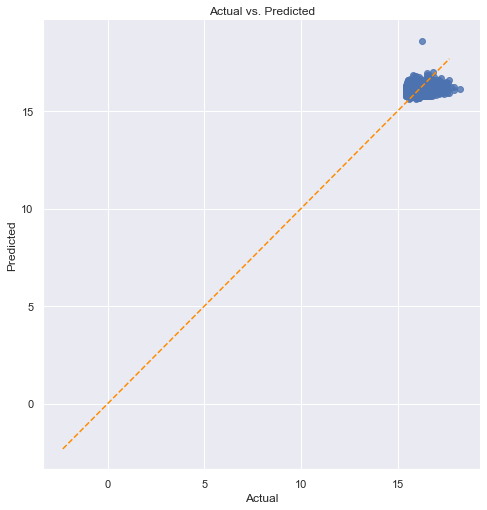

In [42]:
linear_assumption(model_ols,X_test_ols,y_test_ols)

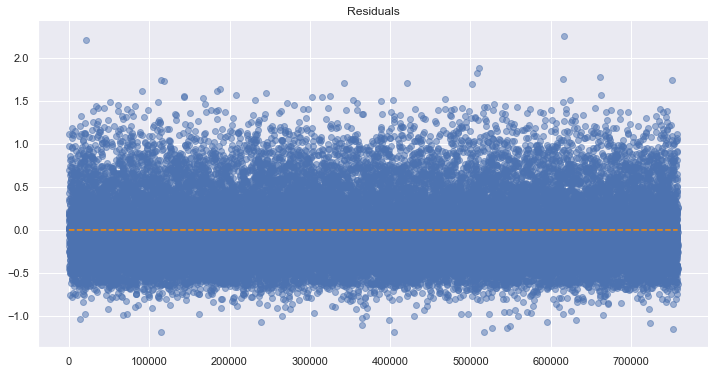

In [43]:
homoscedasticity_assumption(model_ols,X_train_ols,y_train_ols)

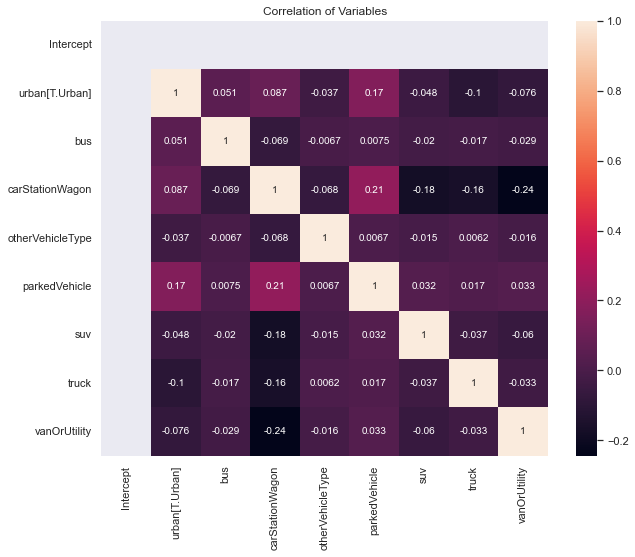

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Intercept: 5.189996237329204
urban[T.Urban]: 1.0578301450000076
bus: 1.01327416136234
carStationWagon: 1.2388027365830172
otherVehicleType: 1.0095496583674926
parkedVehicle: 1.100195360412136
suv: 1.0669879311632897
truck: 1.0580601060029775
vanOrUtility: 1.108504326697488

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied


In [44]:
multicollinearity_assumption(model_ols,X_train_ols,y_train_ols,X_train_ols.columns)

Residuals are normally distributed


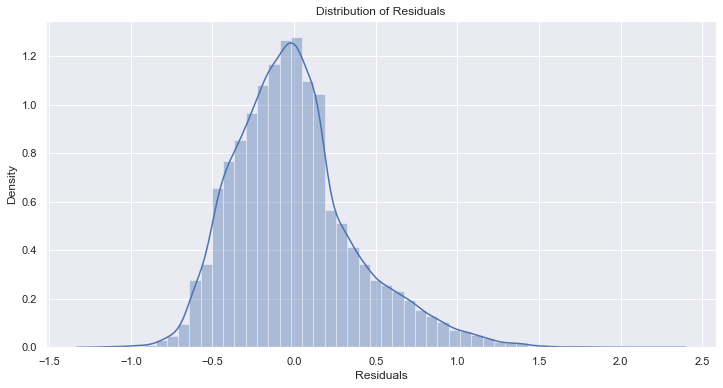

In [45]:
normal_errors_assumption(model_ols,X_train_ols,y_train_ols)

In [46]:
ypred_ltrain = model_ols.predict(X_train_ols)
RMSE_ltrain = np.sqrt(mean_squared_error(y_train_ols,ypred_ltrain))
print("RMSE Of Log-Normal for train:",RMSE_ltrain)
MAE_ltrain = mean_absolute_error(y_train_ols,ypred_ltrain)
print("MAE Of Log-Normal for train:",MAE_ltrain)

RMSE Of Log-Normal for train: 0.37457801387541134
MAE Of Log-Normal for train: 0.28600800190682624


In [47]:
ypred_ltest = model_ols.predict(X_test_ols)
RMSE_ltest = np.sqrt(mean_squared_error(y_test_ols,ypred_ltest))
print("RMSE Of Log-Normal for test:",RMSE_ltest)
MAE_ltest = mean_absolute_error(y_test_ols,ypred_ltest)
print("MAE Of Log-Normal for test:",MAE_ltest)

RMSE Of Log-Normal for test: 0.3770529523292577
MAE Of Log-Normal for test: 0.28684438410733587


In [48]:
print(RMSE_ltrain/(y_train_ols.max()-y_train_ols.min()))
print(RMSE_ltest/(y_test_ols.max()-y_test_ols.min()))

Log_claimAmount    0.124724
dtype: float64
Log_claimAmount    0.133937
dtype: float64


In [49]:
df_ols_results_t = calculate_residuals(model_ols,X_train_ols,y_train_ols,True)
df_ols_results_t.head()

,Actual,Predicted,ActualT,PredictedT,Residuals,Residuals_per
154635,17.018183,16.245809,24598185.0,1.136227e+07,1.323591e+07,0.538085
145056,15.689684,15.948573,6515431.0,8.440679e+06,-1.925248e+06,0.295491
134863,16.391033,16.115127,13138183.0,9.970357e+06,3.167826e+06,0.241116
516006,15.955149,15.948573,8496362.0,8.440679e+06,5.568296e+04,0.006554
410960,16.835274,16.259575,20486449.0,1.151977e+07,8.966677e+06,0.437688


In [50]:
df_ols_results = calculate_residuals(model_ols,X_test_ols,y_test_ols,True)
df_ols_results.head()

,Actual,Predicted,ActualT,PredictedT,Residuals,Residuals_per
78998,15.669780,16.074856,6387031.0,9.576815e+06,-3.189784e+06,0.499416
158493,15.796409,16.259575,7249253.0,1.151977e+07,-4.270519e+06,0.589098
291929,16.406856,16.259575,13347718.0,1.151977e+07,1.827946e+06,0.136948
80365,15.589612,16.132841,5894983.0,1.014854e+07,-4.253559e+06,0.721556
150572,15.581374,16.074856,5846619.0,9.576815e+06,-3.730196e+06,0.638009


In [51]:
RMSE_ltrain = np.sqrt(mean_squared_error(df_ols_results_t['ActualT'],df_ols_results_t['PredictedT']))
print("RMSE Of Log-Normal for train:",RMSE_ltrain)
MAE_ltrain = mean_absolute_error(df_ols_results_t['ActualT'],df_ols_results_t['PredictedT'])
print("MAE Of Log-Normal for train:",MAE_ltrain)

RMSE Of Log-Normal for train: 5036593.772370072
MAE Of Log-Normal for train: 3096360.934914643


In [52]:
RMSE_ltest = np.sqrt(mean_squared_error(df_ols_results['ActualT'],df_ols_results['PredictedT']))
print("RMSE Of Log-Normal for test:",RMSE_ltest)
MAE_ltest = mean_absolute_error(df_ols_results['ActualT'],df_ols_results['PredictedT'])
print("MAE Of Log-Normal for test:",MAE_ltest)

RMSE Of Log-Normal for test: 5226441.3808520585
MAE Of Log-Normal for test: 3129525.4716202086


In [53]:
print(RMSE_ltrain/(df_ols_results_t['ActualT'].max()-df_ols_results_t['ActualT'].min()))
print(RMSE_ltest/(df_ols_results['ActualT'].max()-df_ols_results['ActualT'].min()))

0.052044821432288446
0.06587189614328738


In [54]:
df_ols_results[df_ols_results['Residuals_per']<.5]

,Actual,Predicted,ActualT,PredictedT,Residuals,Residuals_per
78998,15.669780,16.074856,6387031.0,9.576815e+06,-3.189784e+06,0.499416
291929,16.406856,16.259575,13347718.0,1.151977e+07,1.827946e+06,0.136948
281057,15.558831,15.948573,5716290.0,8.440679e+06,-2.724389e+06,0.476601
342847,16.097371,16.119527,9794885.0,1.001432e+07,-2.194346e+05,0.022403
234195,16.120729,15.763854,10026368.0,7.017050e+06,3.009318e+06,0.300140
...,...,...,...,...,...,...
660351,15.930689,16.074856,8291066.0,9.576815e+06,-1.285749e+06,0.155076
205374,15.892172,15.948573,7977793.0,8.440679e+06,-4.628860e+05,0.058022
317894,15.892154,16.074856,7977647.0,9.576815e+06,-1.599168e+06,0.200456
612184,16.401008,15.948573,13269888.0,8.440679e+06,4.829209e+06,0.363922


In [55]:
df_ols_results[df_ols_results['Residuals_per']>.5]

,Actual,Predicted,ActualT,PredictedT,Residuals,Residuals_per
158493,15.796409,16.259575,7249253.0,1.151977e+07,-4.270519e+06,0.589098
80365,15.589612,16.132841,5894983.0,1.014854e+07,-4.253559e+06,0.721556
150572,15.581374,16.074856,5846619.0,9.576815e+06,-3.730196e+06,0.638009
350281,15.652182,16.074856,6275614.0,9.576815e+06,-3.301201e+06,0.526036
324707,15.525579,16.061089,5529342.0,9.445879e+06,-3.916537e+06,0.708319
...,...,...,...,...,...,...
690606,15.473396,15.948573,5248201.0,8.440679e+06,-3.192478e+06,0.608299
88121,15.512217,15.934807,5455948.0,8.325276e+06,-2.869328e+06,0.525908
157113,15.519881,16.061089,5497924.0,9.445879e+06,-3.947955e+06,0.718081
35633,15.476838,16.350361,5266296.0,1.261455e+07,-7.348250e+06,1.395336


### LIME

In [56]:
explanation_ols = lime(model_ols,X_test_ols,y_test_ols,X_train_ols,y_test_ols,1)
explanation_ols.show_in_notebook()

Prediction :  None    15.890136
dtype: float64
Actual :      Log_claimAmount    15.981924
Name: 63157, dtype: float64
